In [53]:
import numpy as np
from numpy import mean, std, dstack
from pandas import read_csv
from matplotlib import pyplot as plt, pyplot

import keras
from keras.layers import LSTM
from tensorflow.keras.layers import Activation, MaxPooling1D, Dense, Input, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Flatten, BatchNormalization, concatenate
from keras.utils import to_categorical, plot_model
from tensorflow.keras import optimizers
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# set seed to reproduce similar results
np.random.seed(0)

In [54]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/ex1/uard/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/ex1/uard/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [55]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [56]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


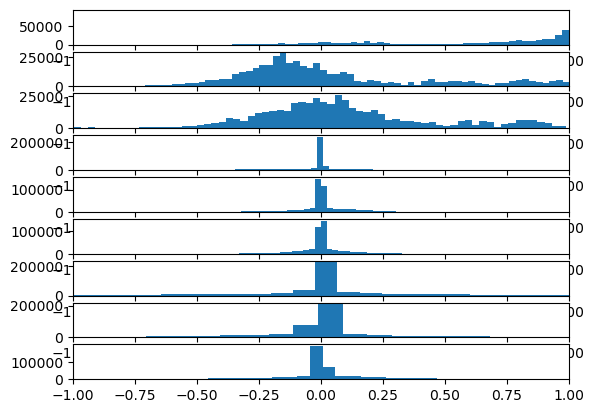

In [57]:
# plot distributions
plot_distributions(trainX)

In [58]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [59]:
from keras.layers import Bidirectional, LSTM
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()

model.add(Bidirectional(LSTM(64), input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [60]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/10
92/92 [==============================] - 41s 282ms/step - loss: 1.1802 - accuracy: 0.5079 - val_loss: 0.9335 - val_accuracy: 0.6247
Epoch 2/10
92/92 [==============================] - 13s 137ms/step - loss: 0.7222 - accuracy: 0.7058 - val_loss: 0.8239 - val_accuracy: 0.7478
Epoch 3/10
92/92 [==============================] - 12s 135ms/step - loss: 0.5032 - accuracy: 0.8118 - val_loss: 0.6859 - val_accuracy: 0.8273
Epoch 4/10
92/92 [==============================] - 12s 133ms/step - loss: 0.4217 - accuracy: 0.8495 - val_loss: 0.5174 - val_accuracy: 0.8600
Epoch 5/10
92/92 [==============================] - 12s 136ms/step - loss: 0.2990 - accuracy: 0.8976 - val_loss: 0.4891 - val_accuracy: 0.8538
Epoch 6/10
92/92 [==============================] - 12s 134ms/step - loss: 0.2361 - accuracy: 0.9191 - val_loss: 0.4316 - val_accuracy: 0.8878
Epoch 7/10
92/92 [==============================] - 13s 138ms/step - loss: 0.2351 - accuracy: 0.9111 - val_loss: 0.4004 - val_accuracy: 0.8749

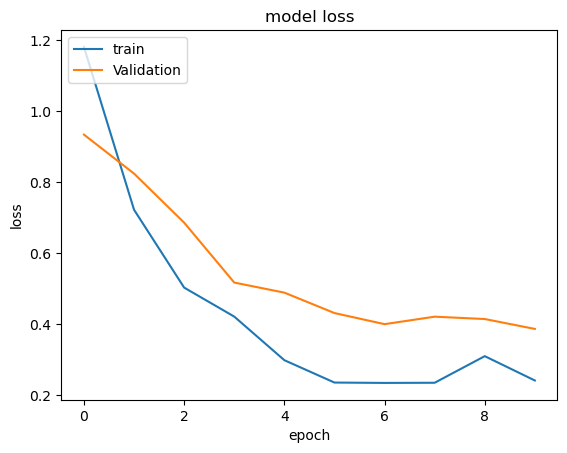

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [62]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the LSTM model 0.8775025606155396
93/93 [==============================] - 3s 24ms/step


In [63]:
predictions

array([[1.0138376e-03, 1.6914689e-04, 1.4636530e-06, 4.1899090e-03,
        9.9462515e-01, 4.5956421e-07],
       [8.1416400e-04, 1.5018179e-04, 1.5663373e-06, 6.5351105e-03,
        9.9249822e-01, 6.8309805e-07],
       [7.6067168e-04, 1.5796477e-04, 1.3665276e-06, 5.6419666e-03,
        9.9343747e-01, 5.9185510e-07],
       ...,
       [1.5143096e-02, 9.8358732e-01, 8.1429182e-04, 1.0398545e-04,
        2.6812151e-04, 8.3123166e-05],
       [4.0283623e-01, 5.6512547e-01, 1.1989118e-03, 1.6885388e-03,
        2.8830104e-02, 3.2077843e-04],
       [4.3499451e-02, 9.5338708e-01, 5.0944352e-04, 2.9032232e-04,
        2.1247859e-03, 1.8894118e-04]], dtype=float32)

**** Confusion Matrix ****
[[424  43  28   0   1   0]
 [ 34 406  31   0   0   0]
 [  7   1 412   0   0   0]
 [  1   8   0 383  99   0]
 [  5   2   1  72 452   0]
 [  0  28   0   0   0 509]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.90      0.85      0.88       496
           2       0.83      0.86      0.85       471
           3       0.87      0.98      0.92       420
           4       0.84      0.78      0.81       491
           5       0.82      0.85      0.83       532
           6       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.88      0.88      0.88      2947
weighted avg       0.88      0.88      0.88      2947



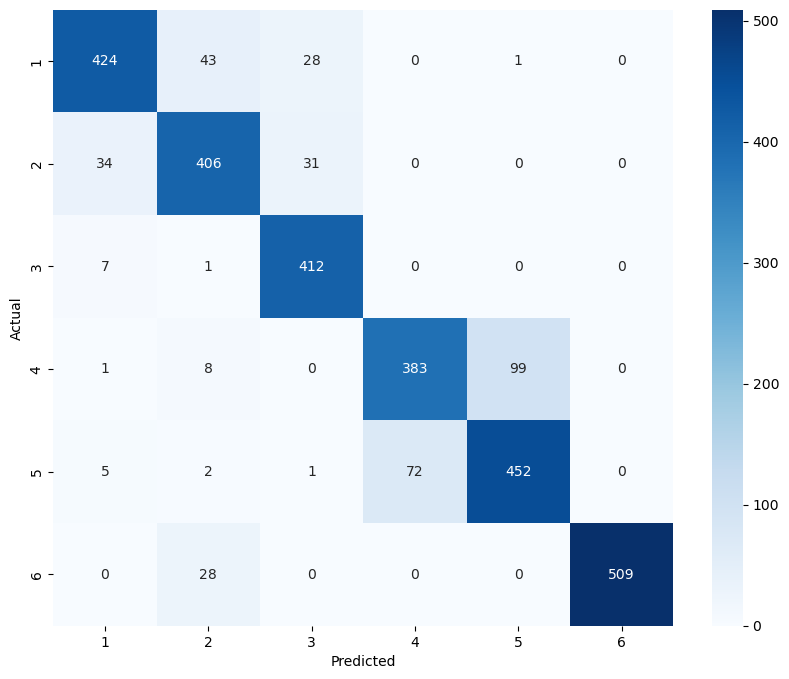

In [64]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)

In [65]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [66]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
train_epochs = 20
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)


Epoch 1/20
92/92 [==============================] - 11s 89ms/step - loss: 1.3756 - accuracy: 0.4013 - val_loss: 1.3800 - val_accuracy: 0.3895
Epoch 2/20
92/92 [==============================] - 8s 81ms/step - loss: 1.2918 - accuracy: 0.4566 - val_loss: 1.3340 - val_accuracy: 0.4392
Epoch 3/20
92/92 [==============================] - 8s 82ms/step - loss: 0.9880 - accuracy: 0.5926 - val_loss: 0.8949 - val_accuracy: 0.6812
Epoch 4/20
92/92 [==============================] - 8s 83ms/step - loss: 0.8457 - accuracy: 0.6341 - val_loss: 0.9362 - val_accuracy: 0.6635
Epoch 5/20
92/92 [==============================] - 8s 82ms/step - loss: 0.7000 - accuracy: 0.7011 - val_loss: 0.8399 - val_accuracy: 0.7220
Epoch 6/20
92/92 [==============================] - 7s 81ms/step - loss: 0.6041 - accuracy: 0.7468 - val_loss: 0.6708 - val_accuracy: 0.7580
Epoch 7/20
92/92 [==============================] - 8s 87ms/step - loss: 0.5408 - accuracy: 0.7875 - val_loss: 0.6572 - val_accuracy: 0.8015
Epoch 8/20
9

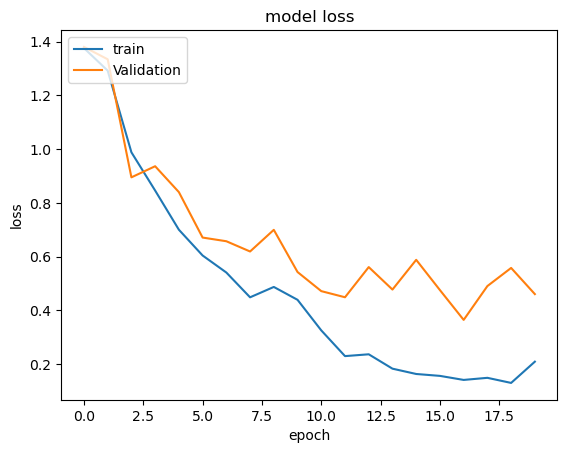

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [68]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)
predictions=model.predict(testX)

Accuracy of the CNN model 0.8187987804412842
93/93 [==============================] - 5s 35ms/step


**** Confusion Matrix ****
[[328  43  33   5  87   0]
 [ 11 401  36   4  19   0]
 [ 17  27 367   1   8   0]
 [  0   4   1 398  88   0]
 [  1   4   2  99 426   0]
 [  0  43   0   1   0 493]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.92      0.66      0.77       496
           2       0.77      0.85      0.81       471
           3       0.84      0.87      0.85       420
           4       0.78      0.81      0.80       491
           5       0.68      0.80      0.73       532
           6       1.00      0.92      0.96       537

    accuracy                           0.82      2947
   macro avg       0.83      0.82      0.82      2947
weighted avg       0.83      0.82      0.82      2947



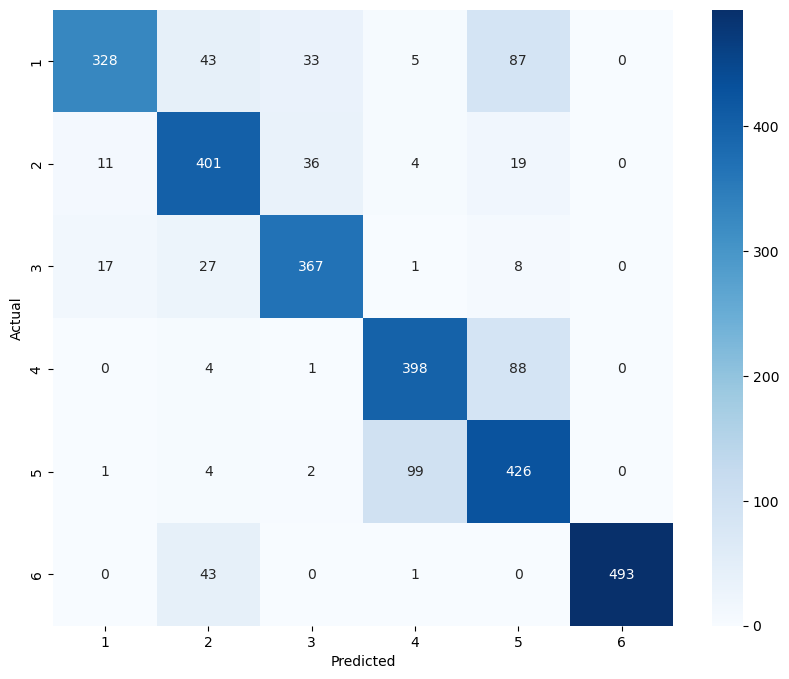

In [69]:
display_results(testy,predictions,classNames)